# Duane–Hunt Law: X-ray Bremsstrahlung Analysis

**Date:** 12/11/2025  
**Author:** Joshua Bowley  

## Aim

This notebook analyses X-ray bremsstrahlung spectra taken at different tube voltages.  
The goals are:

- to extract the **cut-off wavelength** \(\lambda_{\min}\) for each spectrum using Bragg’s law,
- to propagate angular and fitting uncertainties into \(\lambda_{\min}\),
- to perform a **weighted linear regression** of \(1/\lambda_{\min}\) versus tube voltage \(V\),
- to obtain an experimental value for **Planck’s constant** \(h\) and compare it with the accepted value.

## 0. Experimental parameters

The experiment uses Bragg reflection from the (100) face of NaCl.  

Key relations:

- **Duane–Hunt law**  
  $$
  eV = h\nu_{\max} = \frac{hc}{\lambda_{\min}}
  \quad\Rightarrow\quad
  \frac{1}{\lambda_{\min}} = \frac{e}{hc} V
  $$

- **Bragg’s law (first order, \(n = 1\))**  
  $$
  \lambda = 2 d \sin\theta
  $$

Where:
- $d = 0.283\ \text{nm}$ is the NaCl (100) effective plane spacing used in this experiment.
- $\theta$ is the **crystal angle**; the apparatus is run in **COUPLED** mode so the displayed angle is $\theta$.

Uncertainties:
- Angular step / alignment: we model an effective angular uncertainty $\Delta\theta$ (in degrees),
- Voltage readout uncertainty $\Delta V$ (in kV),
- Additional uncertainty from the **linear fit** to the rising edge is included through the covariance of the fit parameters.

In [150]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import constants

In [152]:
# Display options
pd.set_option("display.precision", 4)
pd.set_option("display.max_columns", 20)

In [154]:
# Physical constants
d = 0.283e-9          # NaCl spacing used in lab (m)
e = constants.e       # Elementary charge (C)
c = constants.c       # Speed of light (m/s)
h_theoretical = constants.h  # Accepted Planck constant (J·s)

In [156]:
print(f"d = {d:.3e} m")
print(f"h_theoretical = {h_theoretical:.4e} J·s")

d = 2.830e-10 m
h_theoretical = 6.6261e-34 J·s


### 0.1 Experimental Uncertainties

Angular uncertainty (resolution + alignment):

$$
\Delta\theta = 0.10^\circ
$$

High-voltage uncertainty:

$$
\Delta V = 0.10 \,\text{kV}
$$

These uncertainties propagate into $\lambda_{\min}$ and ultimately $h$.


In [159]:
df = pd.read_csv(r"C:\Users\joshb\OneDrive\PHYSICS BSc UNIVERSITY of EXETER\BSc Physics Stage 2\Practical Physics II\Lab 1\duane hunt data\duane hunt data.csv")
display(df.head())
print("Data shape:", df.shape)

,angle_deg,R2,R3,R4,R5,R6,R7,R8,R9,R10
0,2.5,0.2,0.4,0.6,1.4,2.0,3.4,5.8,4.8,9.1
1,2.6,0.2,0.6,0.8,1.4,1.3,2.4,6.1,4.6,6.3
2,2.7,0.2,0.5,1.1,1.6,1.9,2.0,4.8,5.8,8.1
3,2.8,0.3,0.3,1.0,2.0,1.5,2.9,3.2,5.9,7.9
4,2.9,0.2,0.3,0.5,0.9,1.5,2.9,4.4,6.6,7.3


Data shape: (101, 10)


In [161]:
voltage_mapping = {
    "R2": 15.0,
    "R3": 17.5, 
    "R4": 20.0,
    "R5": 22.5,
    "R6": 25.0,
    "R7": 27.5,
    "R8": 30.0,
    "R9": 32.5,
    "R10": 35.0
}
voltage_mapping

{'R2': 15.0,
 'R3': 17.5,
 'R4': 20.0,
 'R5': 22.5,
 'R6': 25.0,
 'R7': 27.5,
 'R8': 30.0,
 'R9': 32.5,
 'R10': 35.0}

## 1. Initial Visualisation

I plot all $I(\theta)$ spectra to inspect:

- the bremsstrahlung continuum,
- characteristic peaks,
- the low-angle rising edge that contains $\lambda_{\min}$.


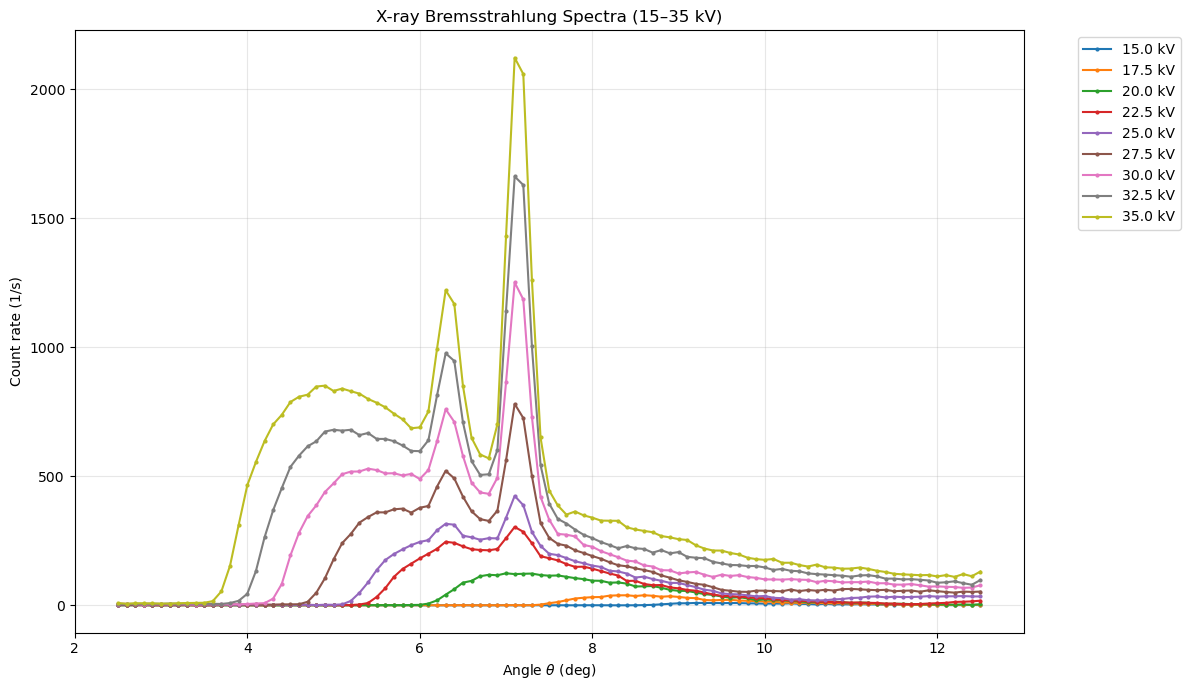

In [164]:
plt.figure(figsize=(12,7))
for col, V in voltage_mapping.items():
    plt.plot(df["angle_deg"], df[col], 'o-', markersize=2, label=f"{V} kV")

plt.xlabel(r"Angle $\theta$ (deg)")
plt.ylabel("Count rate (1/s)")
plt.title("X-ray Bremsstrahlung Spectra (15–35 kV)")
plt.grid(alpha=0.3)
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.savefig("bremsstrahlung_spectra.png", dpi=300, bbox_inches="tight")
plt.show()

## 2. Extracting the Cut-off Angle $\theta_{\min}$

The Duane–Hunt cut-off corresponds to the *sharp rise* at the smallest angle.

Procedure:

1. Smooth counts.
2. Compute derivative $\frac{dI}{d\theta}$.
3. In the low-angle region (first 40%), locate the steepest rising edge (max derivative).
4. Fit a straight line:
   $$
   I(\theta) = m\theta + c
   $$
5. Solve for $I=0$:
   $$
   \theta_{\min} = -\frac{c}{m}
   $$

Uncertainty propagation:

If

$$
\theta_{\min} = -\frac{c}{m}
$$

then

$$
(\Delta\theta_{\min})^2
=
\left(\frac{\partial\theta}{\partial m}\Delta m\right)^2
+
\left(\frac{\partial\theta}{\partial c}\Delta c\right)^2
$$

with

$$
\frac{\partial\theta}{\partial m} = \frac{c}{m^2},
\quad
\frac{\partial\theta}{\partial c} = -\frac{1}{m}.
$$

I also add the base angular uncertainty $\Delta\theta$ in quadrature.


In [166]:
def linear_model(theta, m, c):
    return m*theta + c

In [167]:
def smooth(y, n=5):
    return np.convolve(y, np.ones(n)/n, mode="same")

In [168]:
def find_cutoff_theta(theta_deg, counts, smooth_window=5, edge_window=4):
    theta = np.asarray(theta_deg)
    counts = np.asarray(counts)

    smooth_counts = smooth(counts, n=smooth_window)

    # Restrict to 40% of scan
    limit = int(0.4 * len(theta))
    theta_low = theta[:limit]
    counts_low = smooth_counts[:limit]

    dI = np.gradient(counts_low, theta_low)
    edge_idx = np.argmax(dI)

    i0 = max(0, edge_idx - edge_window)
    i1 = min(limit, edge_idx + edge_window + 1)

    theta_reg = theta_low[i0:i1]
    counts_reg = counts_low[i0:i1]

    sigma = np.sqrt(np.clip(counts_reg, 1, None))

    m_guess = (counts_reg[-1] - counts_reg[0]) / (theta_reg[-1] - theta_reg[0] + 1e-9)
    c_guess = counts_reg[0] - m_guess * theta_reg[0]

    popt, pcov = curve_fit(
        linear_model,
        theta_reg,
        counts_reg,
        p0=[m_guess, c_guess],
        sigma=sigma,
        absolute_sigma=True
    )
    m, c = popt
    m_err, c_err = np.sqrt(np.diag(pcov))

    theta_min = -c/m

    dtheta_dm = c / (m*m)
    dtheta_dc = -1/m

    theta_fit_err = np.sqrt((dtheta_dm*m_err)**2 + (dtheta_dc*c_err)**2)

    return theta_min, theta_fit_err, (theta_reg, counts_reg, popt)

In [169]:
delta_theta_deg = 0.10

In [170]:
results = []
for col, V_kV in voltage_mapping.items():
    
    theta_deg = df["angle_deg"].values
    counts = df[col].values

    # Skip spectra that are too weak
    MIN_PEAK_COUNTS = 4.0
    
    if counts.max() < MIN_PEAK_COUNTS:
        # Store NaNs so the regression ignores this voltage
        results.append({
            "Voltage_kV": V_kV,
            "theta_min_deg": np.nan,
            "theta_min_err_deg": np.nan,
            "lambda_min_m": np.nan,
            "lambda_min_err_m": np.nan
        })
        print(f"Skipped {V_kV:.1f} kV (signal too weak).")
        continue
    
    # Normal cutoff extraction
    theta_min, theta_fit_err, fit_info = find_cutoff_theta(theta_deg, counts)
    theta_min_err_total = np.sqrt(theta_fit_err**2 + delta_theta_deg**2)
    
    theta_rad = np.deg2rad(theta_min)
    theta_err_rad = np.deg2rad(theta_min_err_total)
    
    lambda_min = 2*d*np.sin(theta_rad)
    lambda_min_err = 2*d*np.cos(theta_rad)*theta_err_rad
    
    results.append({
        "Voltage_kV": V_kV,
        "theta_min_deg": theta_min,
        "theta_min_err_deg": theta_min_err_total,
        "lambda_min_m": lambda_min,
        "lambda_min_err_m": lambda_min_err
    })

In [171]:
results_df = pd.DataFrame(results).sort_values("Voltage_kV")
display(results_df)

,Voltage_kV,theta_min_deg,theta_min_err_deg,lambda_min_m,lambda_min_err_m
0,15.0,2.3278,36.0170,2.2989e-11,3.5550e-10
1,17.5,6.0556,154.6177,5.9709e-11,1.5189e-09
2,20.0,5.9630,1.0259,5.8800e-11,1.0080e-11
3,22.5,5.2784,0.3380,5.2069e-11,3.3248e-12
4,25.0,5.0009,0.3007,4.9339e-11,2.9590e-12
5,27.5,4.5826,0.2369,4.5221e-11,2.3328e-12
6,30.0,4.1667,0.1968,4.1124e-11,1.9390e-12
7,32.5,3.8551,0.1742,3.8054e-11,1.7173e-12
8,35.0,3.5575,0.1552,3.5121e-11,1.5307e-12


## 3. From $\theta_{\min}$ to $\lambda_{\min}$

Bragg’s law:

$$
\lambda_{\min} = 2 d \sin\theta_{\min}
$$

Uncertainty:

$$
\Delta\lambda_{\min}
=
\left|2d\cos\theta_{\min}\right|
\,\Delta\theta_{\min}
$$


In [173]:
results_df["V_V"] = results_df["Voltage_kV"]*1e3
results_df["inv_lambda"] = 1/results_df["lambda_min_m"]
results_df["inv_lambda_err"] = results_df["lambda_min_err_m"]/(results_df["lambda_min_m"]**2)

display(results_df)

,Voltage_kV,theta_min_deg,theta_min_err_deg,lambda_min_m,lambda_min_err_m,V_V,inv_lambda,inv_lambda_err
0,15.0,2.3278,36.0170,2.2989e-11,3.5550e-10,15000.0,4.3499e+10,6.7268e+11
1,17.5,6.0556,154.6177,5.9709e-11,1.5189e-09,17500.0,1.6748e+10,4.2603e+11
2,20.0,5.9630,1.0259,5.8800e-11,1.0080e-11,20000.0,1.7007e+10,2.9155e+09
3,22.5,5.2784,0.3380,5.2069e-11,3.3248e-12,22500.0,1.9205e+10,1.2264e+09
4,25.0,5.0009,0.3007,4.9339e-11,2.9590e-12,25000.0,2.0268e+10,1.2155e+09
5,27.5,4.5826,0.2369,4.5221e-11,2.3328e-12,27500.0,2.2113e+10,1.1408e+09
6,30.0,4.1667,0.1968,4.1124e-11,1.9390e-12,30000.0,2.4316e+10,1.1465e+09
7,32.5,3.8551,0.1742,3.8054e-11,1.7173e-12,32500.0,2.6279e+10,1.1859e+09
8,35.0,3.5575,0.1552,3.5121e-11,1.5307e-12,35000.0,2.8473e+10,1.2409e+09


## 4. Weighted Linear Regression

Duane–Hunt predicts:

$$
y = \frac{1}{\lambda_{\min}} = m V,
\qquad
m = \frac{e}{hc}.
$$

Hence:

$$
h = \frac{e}{mc}.
$$

We perform a weighted regression using:

$$
w_i = \frac{1}{\sigma_{y_i}^2}.
$$


In [175]:
def model(V, m):
    return m*V

In [176]:
V = results_df["V_V"].values
y = results_df["inv_lambda"].values
sigma_y = results_df["inv_lambda_err"].values

In [177]:
popt, pcov = curve_fit(model, V, y, sigma=sigma_y, absolute_sigma=True)
m = popt[0]
m_err = np.sqrt(pcov[0,0])

In [178]:
h_exp = e/(m*c)
h_exp_err = h_exp*(m_err/m)

In [182]:
print("m =", m, "+/-", m_err)
print("h_exp =", h_exp, "+/-", h_exp_err)
print("Accepted =", h_theoretical)
print("Percent diff =", 100*(h_exp - h_theoretical)/h_theoretical)

m = 814299.5633380024 +/- 16622.723561330153
h_exp = 6.563046614897891e-34 +/- 1.3397490863480596e-35
Accepted = 6.62607015e-34
Percent diff = -0.9511450026243515


In [186]:
Vfit = np.linspace(min(V)*0.9, max(V)*1.1, 200)
yfit = model(Vfit, m)

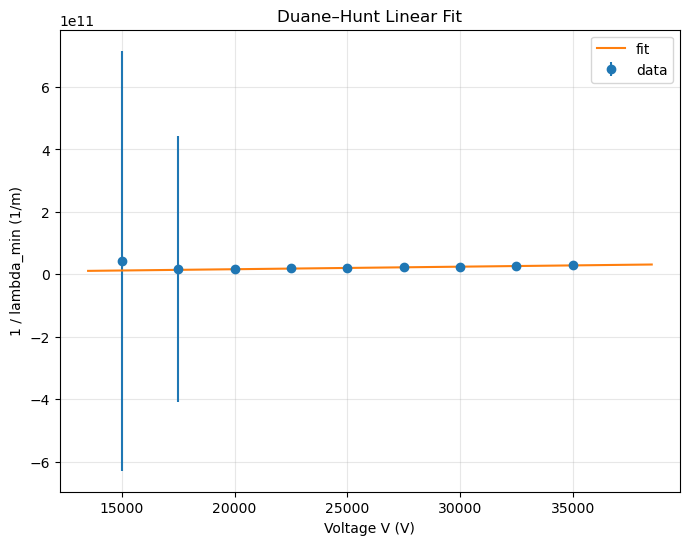

In [187]:
plt.figure(figsize=(8,6))
plt.errorbar(V, y, yerr=sigma_y, fmt='o', label="data")
plt.plot(Vfit, yfit, label="fit")
plt.xlabel("Voltage V (V)")
plt.ylabel("1 / lambda_min (1/m)")
plt.title("Duane–Hunt Linear Fit")
plt.grid(alpha=0.3)
plt.legend()
plt.savefig("duane_hunt_linear_fit.png", dpi=300, bbox_inches="tight")
plt.show()

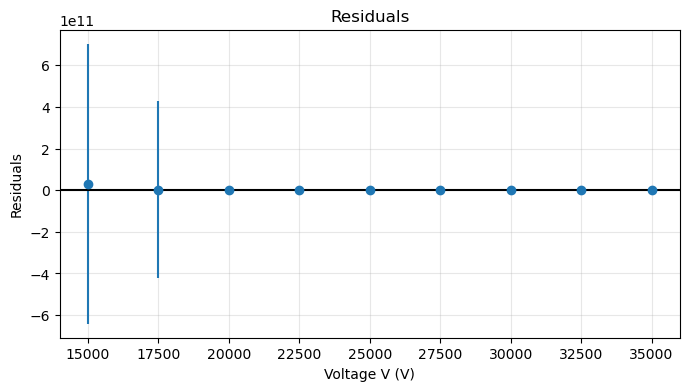

In [190]:
plt.figure(figsize=(8,4))
residuals = y - model(V, m)
plt.errorbar(V, residuals, yerr=sigma_y, fmt='o')
plt.axhline(0, color='k')
plt.xlabel("Voltage V (V)")
plt.ylabel("Residuals")
plt.grid(alpha=0.3)
plt.title("Residuals")

plt.savefig("duane_hunt_residuals.png", dpi=300, bbox_inches="tight")
plt.show()

## 5. Final Result

From the weighted linear regression:

$$
h_{\text{exp}} = (6.56 \pm 0.13)\times 10^{-34}\,\text{J·s}
$$

Accepted value:

$$
h_{\text{theoretical}} = 6.6261\times 10^{-34}\,\text{J·s}
$$

Percentage difference:

$$
\%\,\text{diff}
= -0.95\%.
$$

## 6. Discussion

- The rising-edge linear method provides an objective determination of $\theta_{\min}$.
- Systematic uncertainties come from:
  - alignment of the goniometer,
  - regions chosen for edge fitting,
  - voltage calibration,
  - crystal quality.
- High-voltage points contribute most strongly to determining $h$.
